## **Libraries**

In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib

from wordcloud import WordCloud

import string
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score

# models
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

## **Date Loading**

In [5]:
data = pd.read_csv('spam.csv', encoding='latin-1')

data_original = data.copy()

In [6]:
data_original.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
data_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [8]:
data_original.isnull().sum()

v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64

In [9]:
data_original.describe()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2


## **Data Cleaning**

### **1. Data Cleaning**

In [10]:
# Droping unnecessary columns
data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

# Renaming columns
data.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)

In [11]:
# Apply label encoder in target columns
encoder = LabelEncoder()

data['target'] = encoder.fit_transform(data['target']) # ham: 0, spam: 1

# Save the encoder
with open('Label_Encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)

In [12]:
# Remove duplicates
data.drop_duplicates(inplace=True, keep='first')

### **2. Data Preprocessing**

In [13]:
def transform_text(text):

    text = text.lower()
    text = nltk.word_tokenize(text)
    text = [word for word in text if word.isalnum()]
    text = [word for word in text if word not in stopwords.words('english') and word not in string.punctuation]
    text = [PorterStemmer().stem(word) for word in text]
    text = ' '.join(text)
    
    return text 

In [14]:
data['transformed_text'] = data['text'].apply(transform_text)

In [15]:
data.duplicated().sum()
data.info()
data.shape

<class 'pandas.core.frame.DataFrame'>
Index: 5169 entries, 0 to 5571
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   target            5169 non-null   int32 
 1   text              5169 non-null   object
 2   transformed_text  5169 non-null   object
dtypes: int32(1), object(2)
memory usage: 141.3+ KB


(5169, 3)

## **EDA**

### **1. Numerical Feature Analysis**

#### **1. Target Analysis**

In [16]:
data['target'].value_counts()

target
0    4516
1     653
Name: count, dtype: int64

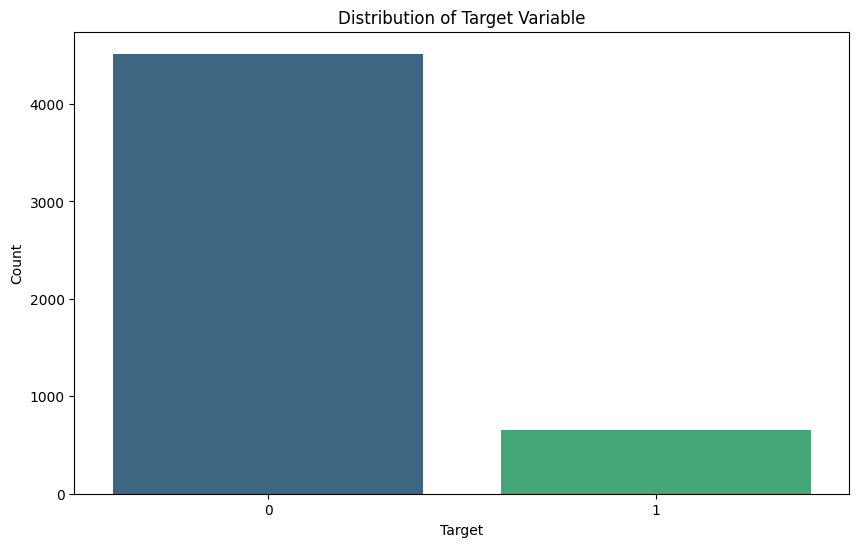

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x=data['target'].value_counts().index, y=data['target'].value_counts().values, palette='viridis')
plt.xlabel('Target')
plt.ylabel('Count')
plt.title('Distribution of Target Variable')
plt.show()

The target column is imbalance 

#### **2. Feature Engineering**

In [18]:
# number of text
data['num_charecters'] = data['text'].apply(len)

In [19]:
# number of words
data['num_words'] = data['text'].apply(lambda x: len(x.split()))

In [20]:
# Number of Sentences
data['num_sentences'] = data['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

#### **3. Ham and Spam Analysis over text**

In [21]:
# Get average values for ham and spam
data_ham = data[data['target'] == 0].groupby('target')[['num_charecters', 'num_words', 'num_sentences']].mean()
data_spam = data[data['target'] == 1].groupby('target')[['num_charecters', 'num_words', 'num_sentences']].mean()

combined = pd.concat([data_ham, data_spam])
combined.index = ['Ham', 'Spam']


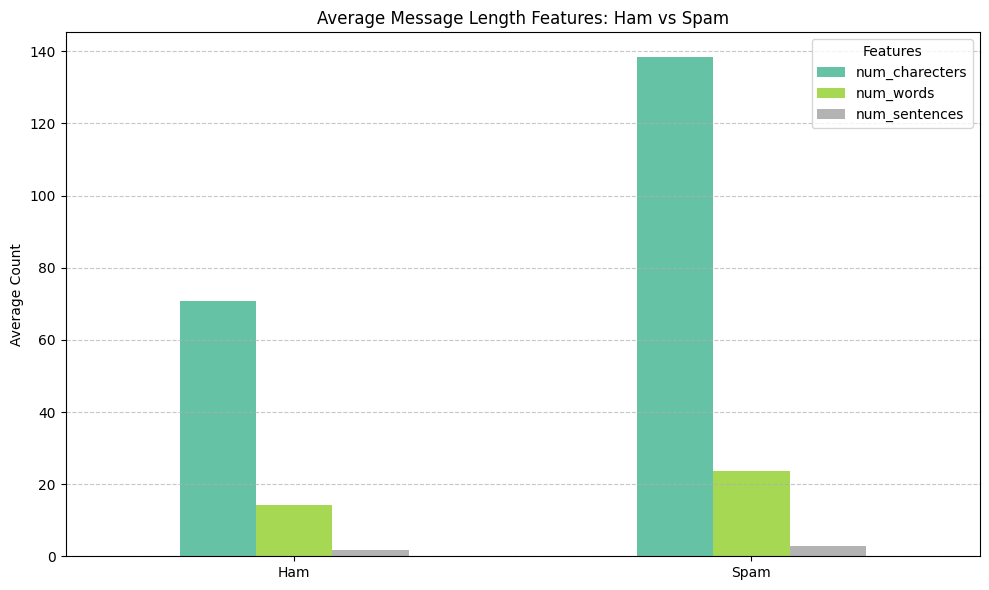

In [22]:
combined.plot(kind='bar', figsize=(10, 6), colormap='Set2')

plt.title('Average Message Length Features: Ham vs Spam')
plt.ylabel('Average Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Features')
plt.tight_layout()
plt.show()


#### **4. Correlation matrix**

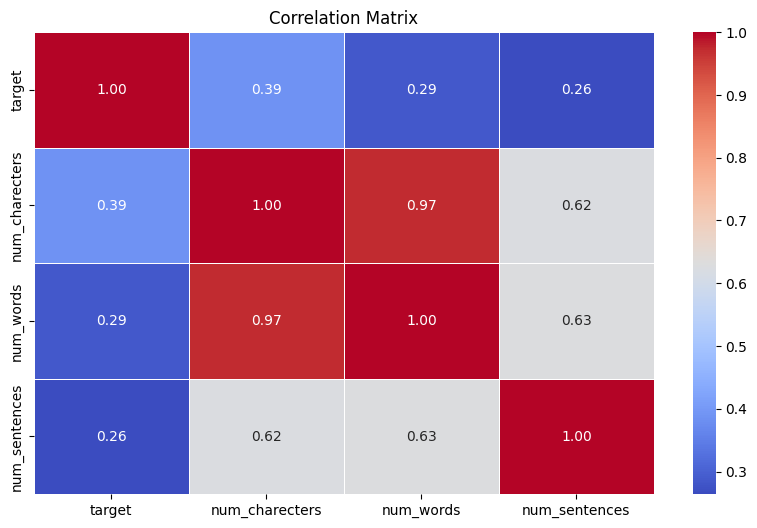

In [23]:
plt.figure(figsize=(10, 6))
numeric_data = data.select_dtypes(include=['int64', 'int32'])
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#### **5. Box Plot**

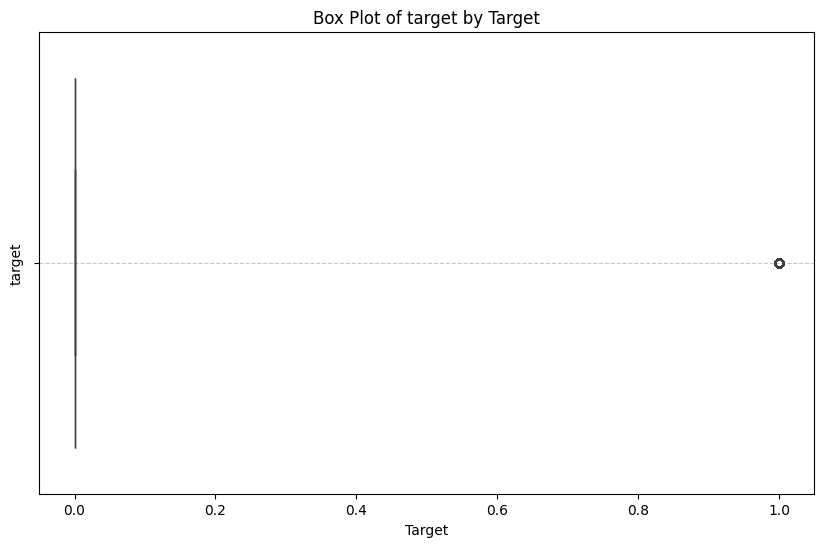

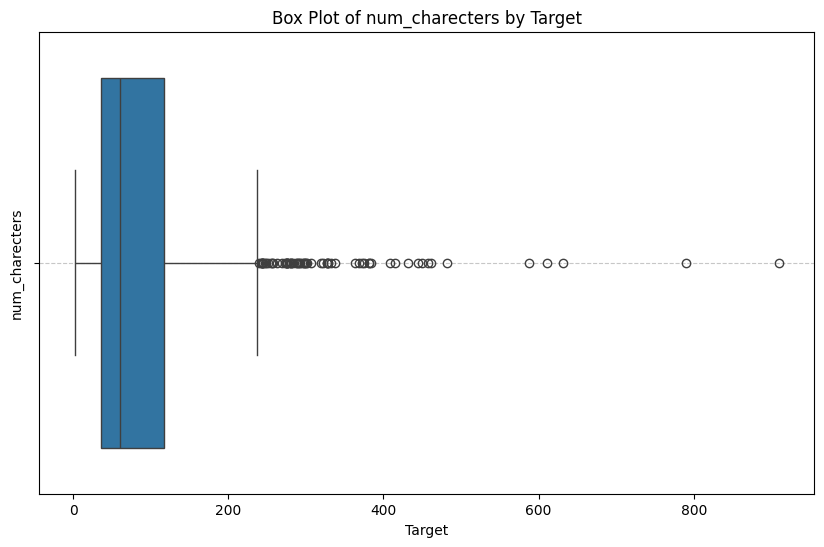

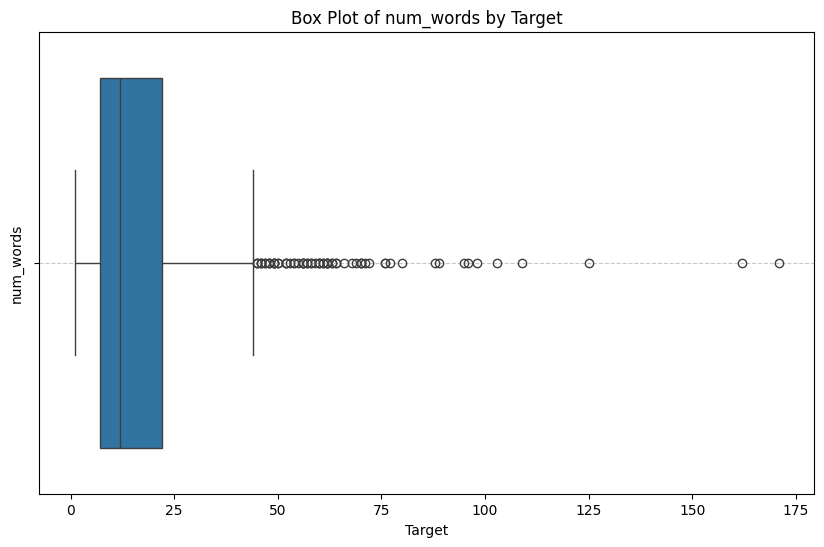

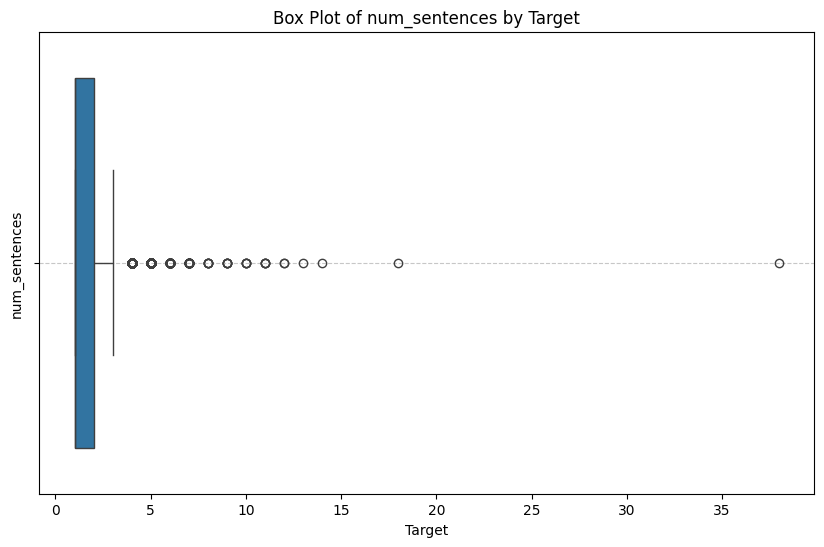

In [24]:
def plot_boxplot(df, col):
    for features in col:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x=df[features])
        plt.title(f'Box Plot of {features} by Target')
        plt.xlabel('Target')
        plt.ylabel(features)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()
        
plot_boxplot(data, numeric_data)

### **2. Categorical Feature Analysis**

#### **1. Most Frequent words in messages**

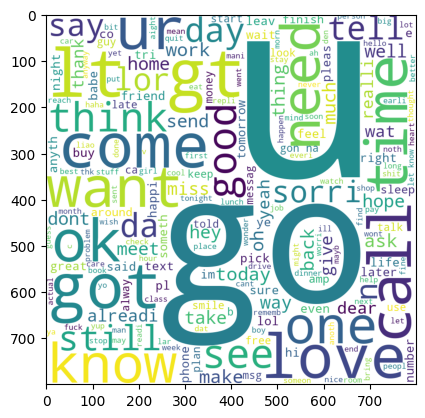

In [25]:
# Create a word cloud for ham messages
wc = WordCloud(
    width=800, 
    height=800, 
    background_color='white', 
    max_words=200
).generate(data[data['target'] == 0]['transformed_text'].str.cat(sep=" "))

plt.imshow(wc)

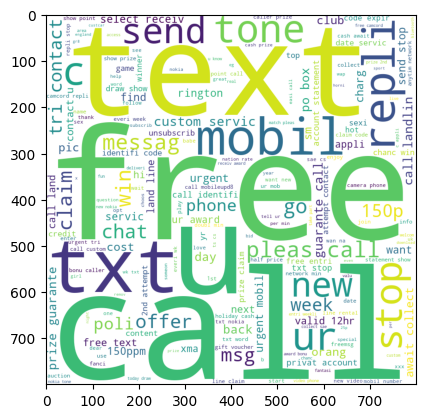

In [26]:
# Create a word cloud for spam messages
wc = WordCloud(
    width=800, 
    height=800, 
    background_color='white', 
    max_words=200
).generate(data[data['target'] == 1]['transformed_text'].str.cat(sep=" "))

plt.imshow(wc)

#### **Top 30 words in Spam and Ham messages**

In [27]:
# Spam
spam_corpus = []

for text in data[data['target'] == 1]['transformed_text'].to_list():
    for words in text.split():
        spam_corpus.append(words)

# Ham
ham_corpus = []

for text in data[data['target'] == 0]['transformed_text'].to_list():
    for words in text.split():
        ham_corpus.append(words)

In [28]:
print(len(spam_corpus), len(ham_corpus))

9936 35305


In [29]:
def most_frequent_words(col):
    word_count = {}

    for word in col:
        if word in word_count:
            word_count[word] += 1
        else:
            word_count[word] = 1

    sorted_words = sorted(word_count.items(), key=lambda item: item[1], reverse=True)
    top_30_words = sorted_words[:30]

    result = [{'word': word, 'count': count} for word, count in top_30_words]
    return result

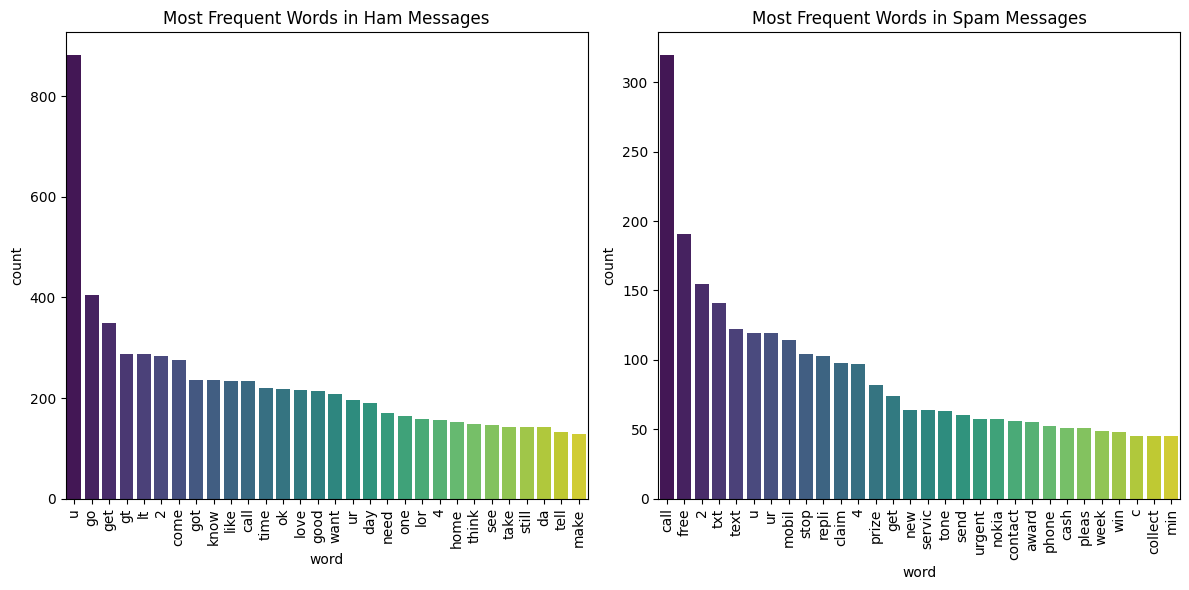

In [30]:
# Ham
data_ham = most_frequent_words(ham_corpus)
df_ham = pd.DataFrame(data_ham) 

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(data=df_ham, x='word', y='count', palette='viridis')
plt.xticks(rotation='vertical')
plt.title('Most Frequent Words in Ham Messages')

# Spam
data_spam = most_frequent_words(spam_corpus)
df_spam = pd.DataFrame(data_spam)

plt.subplot(1, 2, 2)
sns.barplot(data=df_spam, x='word', y='count', palette='viridis')
plt.xticks(rotation='vertical')
plt.title('Most Frequent Words in Spam Messages')

plt.tight_layout()
plt.show()

# **Model Training**

### **1. Spliting The Dataset**

In [31]:
tfidf = TfidfVectorizer(
    ngram_range=(1, 2),  # Use unigrams and bigrams
)

X = tfidf.fit_transform(data['transformed_text']).toarray()
y = data['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### **2. Comparing Models**

In [32]:
models = {
    # naive bayes models
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "BernoulliNB": BernoulliNB()
}

In [33]:
cv_scores = {}

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}

for model_name, model in models.items():
    print(f"Evaluating {model_name} with 5-fold cross-validation...")
    scores = cross_validate(model, X_train, y_train, cv=5, scoring=scoring)
    
    cv_scores[model_name] = {
        metric: np.mean(values) for metric, values in scores.items() if metric.startswith('test_')
    }

    # Print results
    for metric, score in cv_scores[model_name].items():
        print(f"{metric}: {score:.4f}")
    print('-' * 50)

Evaluating GaussianNB with 5-fold cross-validation...
test_accuracy: 0.9100
test_precision: 0.5936
test_recall: 0.8661
test_f1: 0.7037
--------------------------------------------------
Evaluating MultinomialNB with 5-fold cross-validation...
test_accuracy: 0.9245
test_precision: 1.0000
test_recall: 0.3859
test_f1: 0.5560
--------------------------------------------------
Evaluating BernoulliNB with 5-fold cross-validation...
test_accuracy: 0.8996
test_precision: 0.9282
test_recall: 0.1988
test_f1: 0.3260
--------------------------------------------------


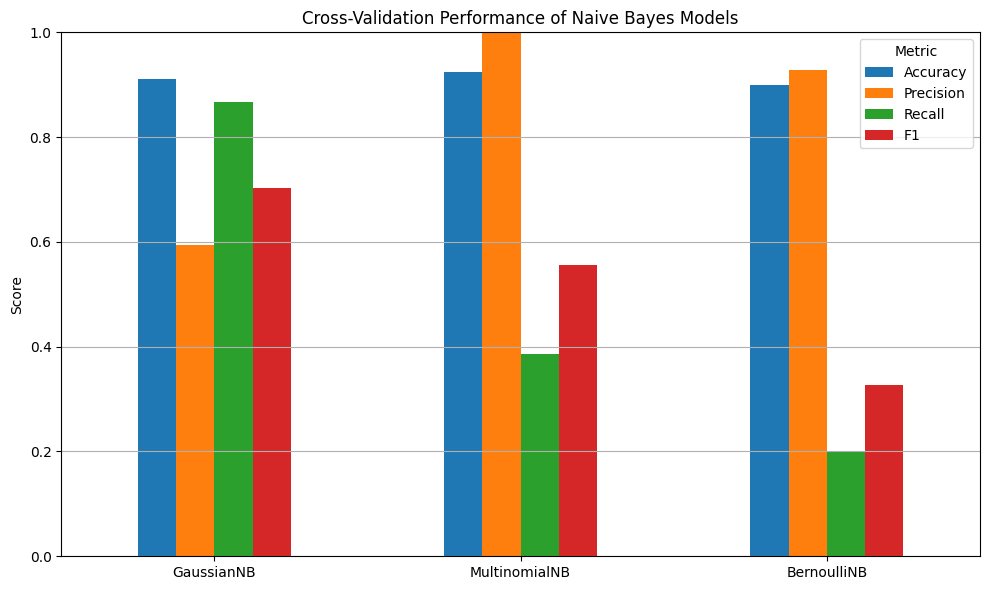

In [34]:
results_df = pd.DataFrame(cv_scores).T  # transpose for easier plotting
results_df.columns = [metric.replace('test_', '').capitalize() for metric in results_df.columns]

results_df.plot(kind='bar', figsize=(10, 6))
plt.title('Cross-Validation Performance of Naive Bayes Models')
plt.ylabel('Score')
plt.xticks(rotation=0)
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

**1. GaussianNB:**
* Best recall (0.85): Good at catching most spam.

* But very low precision (0.49): Many false positives.

* Not ideal unless recall is critical (e.g., better to mark more as spam than miss any).

**2. MultinomialNB:**
* Perfect precision (1.0): No false positives.

* But recall is low (0.57): Misses many spam messages.

* Conservative: only marks spam when very sure.

**3. BernoulliNB:**
* Best overall balance:

* High accuracy (96.6%)

* High precision (0.97) and solid recall (0.74)

* Best F1-score (0.84)

**Best choice overall for spam detection, especially if you're using binary features (e.g., presence/absence of words).**

### **3. Model Training**

In [35]:
model = MultinomialNB()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("\nEvaluation before SMOTE:")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print('-' * 70)

sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

model.fit(X_train_res, y_train_res)

# After retraining on balanced data
y_pred_resampled = model.predict(X_test)

print("\nEvaluation after SMOTE:")
print(classification_report(y_test, y_pred_resampled))
print(confusion_matrix(y_test, y_pred_resampled))


Evaluation before SMOTE:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96       889
           1       1.00      0.54      0.71       145

    accuracy                           0.94      1034
   macro avg       0.97      0.77      0.83      1034
weighted avg       0.94      0.94      0.93      1034

[[889   0]
 [ 66  79]]
----------------------------------------------------------------------

Evaluation after SMOTE:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       889
           1       0.83      0.92      0.87       145

    accuracy                           0.96      1034
   macro avg       0.91      0.95      0.93      1034
weighted avg       0.96      0.96      0.96      1034

[[861  28]
 [ 11 134]]


In [36]:
# save the model
joblib.dump(model, 'spam_detection_model.pkl')

# save the vectorizer
joblib.dump(tfidf, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

# **Prediction**

In [37]:
# Your saved model + vectorizer
model = joblib.load("spam_detection_model.pkl")
tfidf = joblib.load("tfidf_vectorizer.pkl")

# Predict a new message
sample_text = ["Win a free iPhone now!"]
transformed = [transform_text(text) for text in sample_text]
X_input = tfidf.transform(transformed)
prediction = model.predict(X_input)

print("Spam" if prediction[0] == 1 else "Ham")

Spam
